<a href="https://colab.research.google.com/github/mahi-88/Task-5-Data-Science-example.-/blob/main/Task5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the Dataset


In [ ]:
!wget -O complaints.csv.zip "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
!unzip complaints.csv.zip


--2025-10-18 16:35:02--  https://files.consumerfinance.gov/ccdb/complaints.csv.zip
Resolving files.consumerfinance.gov (files.consumerfinance.gov)... 23.216.147.201, 23.216.147.205, 2600:1409:3c00:18::173b:5842, ...
Connecting to files.consumerfinance.gov (files.consumerfinance.gov)|23.216.147.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1566938256 (1.5G) [binary/octet-stream]
Saving to: ‘complaints.csv.zip’

complaints.csv.zip  100%[===================>]   1.46G   132MB/s    in 17s     

2025-10-18 16:35:20 (88.3 MB/s) - ‘complaints.csv.zip’ saved [1566938256/1566938256]

Archive:  complaints.csv.zip
  inflating: complaints.csv          


In [ ]:
import pandas as pd

df = pd.read_csv('complaints.csv', nrows=100000, low_memory=False)
print(df.shape)
df.head()


(100000, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-10-14,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information is missing that should be on the r...,NaN,NaN,"EQUIFAX, INC.",TX,75062,NaN,NaN,Web,2025-10-14,In progress,Yes,NaN,16558024
2,2025-10-10,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",GA,30341,NaN,NaN,Web,2025-10-10,In progress,Yes,NaN,16507707
3,2025-10-15,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,75287,NaN,NaN,Web,2025-10-15,In progress,Yes,NaN,16593757
4,2025-10-03,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,MS,38751,NaN,NaN,Web,2025-10-03,In progress,Yes,NaN,16359589


In [ ]:
!pip install -q scikit-learn xgboost imbalanced-learn matplotlib seaborn nltk wordcloud transformers datasets torch

import os, re, string, random, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
sns.set(style="whitegrid")


Prepare dataset (filter to 4 classes + create text & label)

In [ ]:

def map_category(prod):
    p = str(prod).lower()
    if "credit" in p:
        return 0  # Credit reporting, repair, or other
    elif "debt" in p:
        return 1  # Debt collection
    elif "mortgage" in p:
        return 3  # Mortgage
    elif "loan" in p and "mortgage" not in p:
        return 2  # Consumer Loan
    else:
        return None

df['label'] = df['Product'].apply(map_category)

df['text'] = df['Consumer complaint narrative'].fillna(df['Issue']).astype(str)


df = df[df['label'].notnull() & df['text'].str.strip().ne('')].copy()

print("Rows after filtering:", df.shape[0])
print(df['label'].value_counts())
df = df.reset_index(drop=True)


Rows after filtering: 97397
label
0.0    89582
1.0     5539
2.0     1152
3.0     1124
Name: count, dtype: int64


In [ ]:
from sklearn.utils import resample

df_minority = df[df['label'] != 0]
df_majority = df[df['label'] == 0]

df_majority_down = resample(df_majority,
                            replace=False,
                            n_samples=len(df_minority)*2,
                            random_state=42)

df_balanced = pd.concat([df_majority_down, df_minority])
print(df_balanced['label'].value_counts(normalize=True))


label
0.0    0.666667
1.0    0.236255
2.0    0.049136
3.0    0.047942
Name: proportion, dtype: float64


EXPLORATORY DATA ANALYSIS (EDA)

Class distribution & imbalance

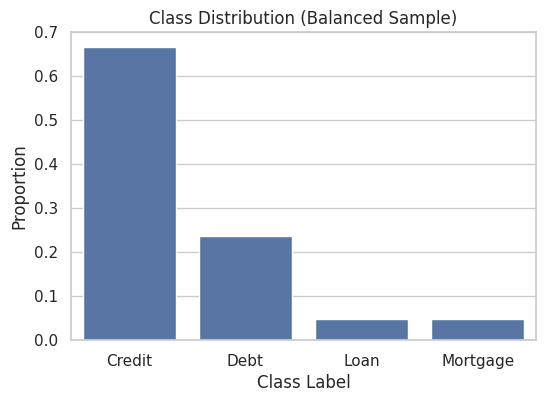

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

proportions = df_balanced['label'].value_counts(normalize=True).sort_index()
labels = ['Credit','Debt','Loan','Mortgage']

plt.figure(figsize=(6,4))
sns.barplot(x=labels, y=proportions.values)
plt.title('Class Distribution (Balanced Sample)')
plt.ylabel('Proportion')
plt.xlabel('Class Label')
plt.show()


Text length distribution

           char_len    word_count
count  23445.000000  23445.000000
mean     157.992237     26.555811
std      512.781944     88.785828
min        5.000000      1.000000
25%       33.000000      5.000000
50%       36.000000      5.000000
75%       51.000000      9.000000
max    11655.000000   2018.000000


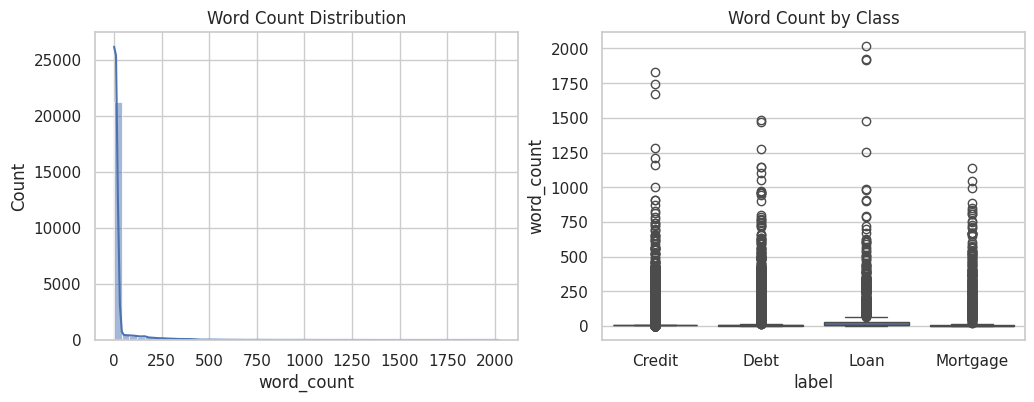

In [ ]:
df_balanced['char_len'] = df_balanced['text'].str.len()
df_balanced['word_count'] = df_balanced['text'].str.split().apply(len)

print(df_balanced[['char_len','word_count']].describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df_balanced['word_count'], bins=50, kde=True)
plt.title('Word Count Distribution')

plt.subplot(1,2,2)
sns.boxplot(x='label', y='word_count', data=df_balanced)
plt.xticks([0,1,2,3], labels)
plt.title('Word Count by Class')
plt.show()


Top frequent words per class

In [ ]:
from collections import Counter
import re

def simple_tokens(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [t for t in tokens if len(t)>2]

for lab in sorted(df_balanced['label'].unique()):
    sample_text = " ".join(df_balanced[df_balanced['label']==lab]['text'].dropna().astype(str))
    cnt = Counter(simple_tokens(sample_text))
    print(f"\nTop 15 words for label {lab}:")
    print(cnt.most_common(15))



Top 15 words for label 0.0:
[('xxxx', 16898), ('report', 13340), ('your', 12246), ('information', 9898), ('incorrect', 8517), ('the', 7147), ('problem', 5263), ('and', 5006), ('with', 3923), ('use', 3315), ('improper', 3264), ('credit', 3123), ('investigation', 2838), ('company', 2776), ('into', 2649)]

Top 15 words for label 1.0:
[('xxxx', 7635), ('the', 6682), ('debt', 4952), ('and', 4397), ('not', 3306), ('this', 2580), ('that', 2376), ('collect', 2045), ('owed', 1923), ('attempts', 1842), ('credit', 1635), ('for', 1323), ('about', 1305), ('with', 1299), ('was', 1297)]

Top 15 words for label 2.0:
[('xxxx', 3539), ('the', 3172), ('and', 2006), ('loan', 1035), ('was', 1007), ('that', 982), ('for', 793), ('with', 761), ('this', 723), ('they', 653), ('have', 615), ('not', 591), ('your', 434), ('payment', 429), ('from', 388)]

Top 15 words for label 3.0:
[('xxxx', 3228), ('the', 2915), ('and', 1903), ('was', 1065), ('that', 1062), ('loan', 881), ('mortgage', 841), ('for', 782), ('they'

Numeric feature engineering

In [ ]:
def add_numeric_features(df):
    df['digit_count'] = df['text'].apply(lambda s: sum(c.isdigit() for c in s))
    df['upper_count'] = df['text'].apply(lambda s: sum(1 for c in s if c.isupper()))
    df['has_money'] = df['text'].str.contains(r'[$€£]', regex=True).astype(int)
    return df

df_balanced = add_numeric_features(df_balanced)
df_balanced[['digit_count','upper_count','has_money']].describe()


,digit_count,upper_count,has_money
count,23445.000000,23445.000000,23445.000000
mean,1.340499,12.071145,0.030966
std,7.795410,66.760464,0.173230
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000
max,418.000000,3386.000000,1.000000


TEXT PRE-PROCESSING

In [ ]:
import re, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"\d{4,}", " <YEAR> ", text)
    text = re.sub(r"\d+", " <NUM> ", text)
    text = re.sub(r"[^\w\s<>]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_balanced['clean_text'] = df_balanced['text'].apply(clean_text)
df_balanced[['text','clean_text']].head(2)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,clean_text
78800,Incorrect information on your report,incorrect information on your report
13148,Incorrect information on your report,incorrect information on your report


MODEL SELECTION (Multi-class models)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

X = df_balanced['clean_text']
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)

pipe_nb  = Pipeline([('tfidf', tfidf), ('clf', MultinomialNB())])
pipe_lr  = Pipeline([('tfidf', tfidf), ('clf', LogisticRegression(max_iter=1000,class_weight='balanced'))])
pipe_svc = Pipeline([('tfidf', tfidf), ('clf', LinearSVC(class_weight='balanced',max_iter=5000))])



Multinomial Naive Bayes
Accuracy: 0.9441, Macro F1: 0.9004
              precision    recall  f1-score   support

         0.0     0.9880    0.9485    0.9678      3126
         1.0     0.8421    0.9964    0.9128      1108
         2.0     0.9032    0.7304    0.8077       230
         3.0     0.9948    0.8444    0.9135       225

    accuracy                         0.9441      4689
   macro avg     0.9320    0.8799    0.9004      4689
weighted avg     0.9497    0.9441    0.9444      4689



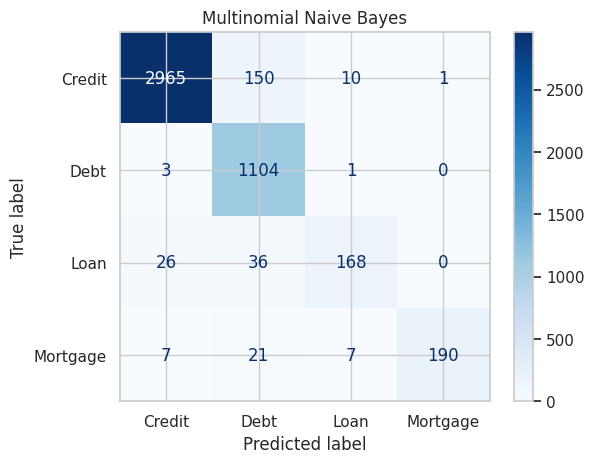


Logistic Regression
Accuracy: 0.9608, Macro F1: 0.9129
              precision    recall  f1-score   support

         0.0     0.9882    0.9651    0.9765      3126
         1.0     0.9500    0.9765    0.9631      1108
         2.0     0.7303    0.8478    0.7847       230
         3.0     0.9174    0.9378    0.9275       225

    accuracy                         0.9608      4689
   macro avg     0.8965    0.9318    0.9129      4689
weighted avg     0.9631    0.9608    0.9616      4689



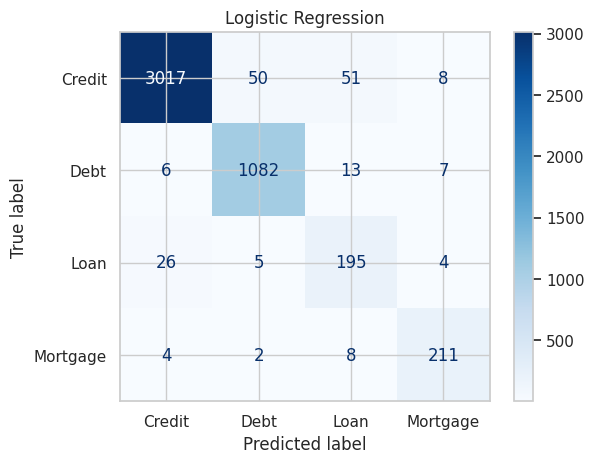


Linear SVC
Accuracy: 0.9733, Macro F1: 0.9381
              precision    recall  f1-score   support

         0.0     0.9850    0.9843    0.9846      3126
         1.0     0.9644    0.9792    0.9718      1108
         2.0     0.8791    0.8217    0.8494       230
         3.0     0.9467    0.9467    0.9467       225

    accuracy                         0.9733      4689
   macro avg     0.9438    0.9330    0.9381      4689
weighted avg     0.9731    0.9733    0.9731      4689



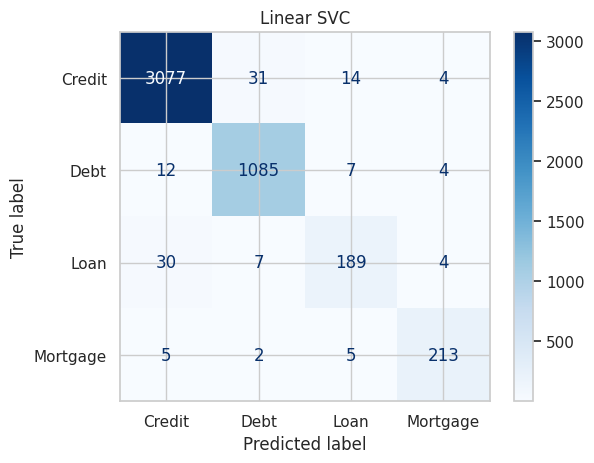

,Model,Accuracy,Macro F1
2,LinearSVC,0.973342,0.938133
1,LogisticRegression,0.960759,0.912944
0,MultinomialNB,0.944125,0.900444


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    print(f"\n{name}\nAccuracy: {acc:.4f}, Macro F1: {f1:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Credit','Debt','Loan','Mortgage']).plot(cmap='Blues')
    plt.title(name)
    plt.show()
    return acc, f1

results=[]
results.append(['MultinomialNB',     *evaluate_model(pipe_nb,  'Multinomial Naive Bayes')])
results.append(['LogisticRegression',*evaluate_model(pipe_lr,  'Logistic Regression')])
results.append(['LinearSVC',         *evaluate_model(pipe_svc, 'Linear SVC')])

pd.DataFrame(results, columns=['Model','Accuracy','Macro F1']).sort_values('Macro F1',ascending=False)


MODEL EVALUATION

In [ ]:
best_model = pipe_lr
y_pred = best_model.predict(X_test)

test_df = pd.DataFrame({'text': X_test, 'true': y_test, 'pred': y_pred})
errors = test_df[test_df['true'] != test_df['pred']].sample(10, random_state=1)

for _, r in errors.iterrows():
    print(f"TRUE={r.true}  PRED={r.pred}")
    print(r.text[:400])
    print('-'*80)


TRUE=0.0  PRED=2.0
in re account xxxx xxxx xxxx xxxx enclosed you will find two checks one in the amount of <NUM> <NUM> the original xxxx xxxx xxxx purchase and the other for <NUM> <NUM> for fraudulent and usurious charges related to the incompetence of xxxx xxxx xxxx and synchrony bank under protest these checks satisfy the unprofessional and incompetent actions of all parties to review the events leading up to thi
--------------------------------------------------------------------------------
TRUE=0.0  PRED=3.0
i have been doing business with barclay bank for approximately <NUM> years this past xx xx xxxx i called to attempt to use some of my points for a xxxx vacation one of the reasons i like the card and pay an extremely high fee is because of the rewards program after four of five calls receiving numerous different reasons of why they could n t access it ca n t find the account computers are down the
-------------------------------------------------------------------------------

PREDICTION

Save and reload model

In [ ]:
import joblib
joblib.dump(best_model, 'consumer_complaint_classifier.pkl')
model = joblib.load('consumer_complaint_classifier.pkl')


In [ ]:
def predict_category(texts):
    preds = model.predict([clean_text(t) for t in texts])
    inv = {0:'Credit Reporting',1:'Debt Collection',2:'Consumer Loan',3:'Mortgage'}
    for t,p in zip(texts,preds):
        print(f"TEXT: {t}\n→ Predicted: {inv[p]}\n")

predict_category([
    "The debt collector keeps calling me for someone else's account.",
    "My credit report still shows closed accounts as open.",
    "The bank raised my mortgage interest rate without notice.",
    "The personal loan repayment schedule is incorrect."
])


TEXT: The debt collector keeps calling me for someone else's account.
→ Predicted: Debt Collection

TEXT: My credit report still shows closed accounts as open.
→ Predicted: Credit Reporting

TEXT: The bank raised my mortgage interest rate without notice.
→ Predicted: Mortgage

TEXT: The personal loan repayment schedule is incorrect.
→ Predicted: Consumer Loan



Model Comparision


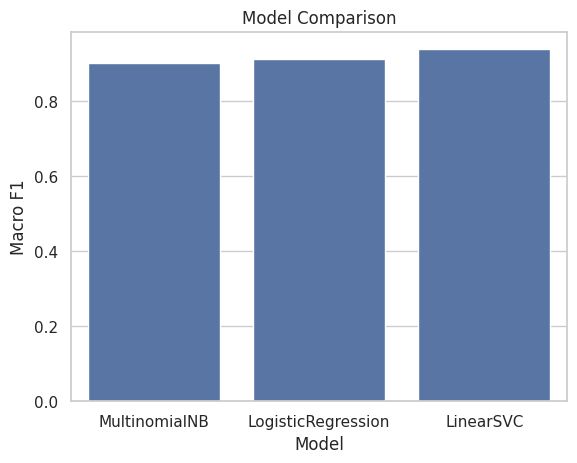

,Model,Accuracy,Macro F1
0,MultinomialNB,0.944125,0.900444
1,LogisticRegression,0.960759,0.912944
2,LinearSVC,0.973342,0.938133


In [ ]:
summary = pd.DataFrame(results, columns=['Model','Accuracy','Macro F1'])
sns.barplot(x='Model', y='Macro F1', data=summary)
plt.title('Model Comparison')
plt.show()
summary
